# To Visualize Lognormal Distribution with differing parameters. Where does it place probability mass? Useful for prior modeling.

In [1]:
# Python Path non-sense
%load_ext autoreload
%autoreload 2

import sys
import os

# remove any paths that contains 'bayes_gsl' in the sys.path
sys.path = [x for x in sys.path if 'bayes_gsl' not in x]
new_path = '/Users/maxw/projects/gsl-bnn/'
if new_path not in sys.path:
    sys.path.append(new_path)

NumPyro parametrizes the lognormal distribution with a loc and scale parameters. Test to see whether this implies ln(X) ~ N(loc, scale).
**Initialize a lognormal RV X with loc=8.05904782547916 and scale=1.4142135623730951**
Formulas for the mean and variance of X: E[X] = exp(loc + scale**2/2), Var[X] = (exp(scale**2) - 1) * exp(2*loc + scale**2)
NumPyro also provides the mean and variance of X directly.
If these match, then we can conclude that ln(X) ~ N(loc, scale).
	E[X]: formula: 8595.961900 vs numpyro: 8595.960938
	analytical Var[X]: 472090939.342136 vs numpyro: 472090848.000000
Mode of X: formula: 427.967743
Median of X: formula: 3162.277660
	sample mean of ln(X): 8.059998 vs loc: 8.059048
	sample std of ln(X): 1.411832 vs scale: 1.414214
largest counts: [247 247 248 249 250 251 254 254 260 266]
largest bin centers: [405.84617849 563.14995099 283.70442572 570.55248146 383.63858707
 446.56009607 313.3145476  474.31958534 548.34489005 452.11199393]
	sample mode of X: 452.111994 vs f

/Users/maxw/opt/miniconda3/envs/gsl-bnn-mac-m2/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Prob mass in relevant intervals
Pr(X < 1.0e-03): 0.000%
Pr(1.0e-03 < X < 1.0e-02): 0.000%
Pr(1.0e-02 < X < 1.0e-01): 0.000%
Pr(1.0e-01 < X < 1.0e+00): 0.000%
Pr(1.0e+00 < X < 1.0e+01): 0.002%
Pr(1.0e+01 < X < 1.0e+02): 0.727%
Pr(1.0e+02 < X < 1.0e+03): 20.050%
Pr(1.0e+03 < X < 1.0e+04): 58.440%
Pr(1.0e+04 < X < 1.0e+05): 20.050%
Pr(X > 1.0e+05): 0.730%
Pr(X < 10^-2): 0.000
Pr(10^-2 < X < 10^-1): 0.000
Pr(10^-1 < X < 10^0): 0.000
Pr(10^0 < X < 10^1): 0.000
Pr(10^1 < X < 10^2): 0.007
Pr(10^2 < X < 10^3): 0.200
Pr(X > 10^3): 0.792


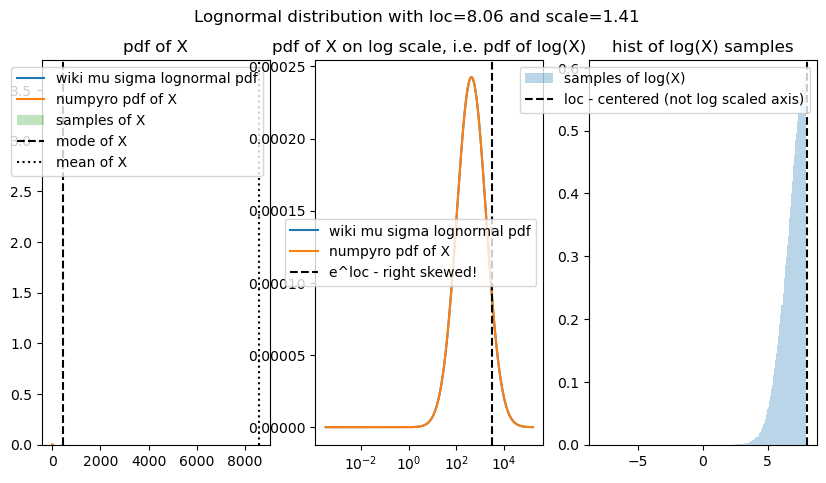

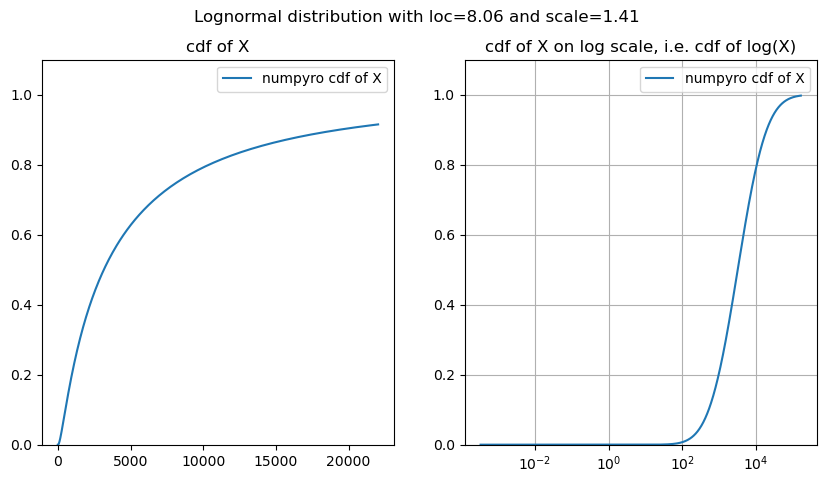

In [2]:
"""
    Clarify the confusing parametrizations of lognormals

    X ~ exp(Z), where Z ~ N(loc, scale)
    We say X ~ LogNormal(loc, scale)

    Indeed in numpyro, we specify the lognormal distribution as:
     - distributions.LogNormal(loc, scale), where log() ~ N(loc, scale)

     Resources:
     - viz link: https://distribution-explorer.github.io/continuous/lognormal.html

"""

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random, vmap
import numpyro.infer

r"""
RG
    \theta: loc, scale = np.log(10 ** 0), np.sqrt(2)
    \delta: loc, scale = np.log(10 ** (3.5)), np.sqrt(2)
    b: loc, scale = np.log(10**.5), np.sqrt(1)


"""

# first ensure we understand how numpyro parametrizes lognormals

theta_loc, theta_scale = np.log(10**(-.5)), np.sqrt(4)
delta_loc, delta_scale = np.log(10**(2)), np.sqrt(2)
b_loc, b_scale = np.log(10**0), np.sqrt(2)

loc = np.log(10**(3.5)) # 2
scale = np.sqrt(2)

print(f"NumPyro parametrizes the lognormal distribution with a loc and scale parameters. "
      f"Test to see whether this implies ln(X) ~ N(loc, scale).")


# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

print(f"**Initialize a lognormal RV X with loc={loc} and scale={scale}**")
dist = numpyro.distributions.LogNormal(loc, scale)

"""
    Compute the analytical mean and variance of X.
    mean = exp(loc + scale**2/2)
    variance = (exp(scale**2) - 1) * exp(2*loc + scale**2)
"""
print(f"Formulas for the mean and variance of X: "
      f"E[X] = exp(loc + scale**2/2), Var[X] = (exp(scale**2) - 1) * exp(2*loc + scale**2)")
print(f"NumPyro also provides the mean and variance of X directly.")
print(f"If these match, then we can conclude that ln(X) ~ N(loc, scale).")
formula_mean = np.exp(loc + scale**2/2)
formula_var = (np.exp(scale**2) - 1) * np.exp(2*loc + scale**2)
print(f"\tE[X]: formula: {formula_mean:5f} vs numpyro: {dist.mean:5f}")
print(f"\tanalytical Var[X]: {formula_var:5f} vs numpyro: {dist.variance:5f}")
assert np.isclose(formula_mean, dist.mean) and np.isclose(formula_var, dist.variance)

formula_mode = np.exp(loc - scale**2)
formula_median = np.exp(loc)
print(f"Mode of X: formula: {formula_mode:5f}")
print(f"Median of X: formula: {formula_median:5f}")
#assert np.isclose(formula_mode, dist.mode)

"""
    Derive some sample statistics from draws of X and ensure the mean of their logs matches loc and the std of their 
    logs matches scale.
"""
samples = dist.sample(rng_key, (500000,))
print(f"\tsample mean of ln(X): {np.mean(np.log(samples)):5f} vs loc: {loc:5f}")
print(f"\tsample std of ln(X): {np.std(np.log(samples)):5f} vs scale: {scale:5f}")
# to compute sample mode, first bin the samples, then find the bin with the most samples
max_sample = np.max(samples)
min_sample = np.min(samples)
bins = np.linspace(min_sample, max_sample, 1000000)
bin_width = bins[1] - bins[0]
bin_centers = bins[:-1] + bin_width / 2
bin_counts = np.histogram(samples, bins=bins)[0]
# print the largest counts with their respective bin centers
print(f"largest counts: {bin_counts[np.argsort(bin_counts)[-10:]]}")
print(f"largest bin centers: {bin_centers[np.argsort(bin_counts)[-10:]]}")
sample_mode = bin_centers[np.argmax(bin_counts)]
print(f"\tsample mode of X: {bin_centers[np.argsort(bin_counts)[-1]]:5f} vs formula: {formula_mode:5f}")
print(f"\tsample median of X: {np.median(samples):5f} vs formula: {formula_median:5f}")
assert np.isclose(np.mean(np.log(samples)), loc, atol=1e-2) and np.isclose(np.std(np.log(samples)), scale, atol=1e-2)


"""
    Plot the pdf of X and the pdf of ln(X) to see if they match expectation
"""


def log_pdf(x, mu, sigma):
    """
        log_pdf of lognormal distribution
    """
    return -np.log(x) - np.log(sigma) - 0.5 * np.log(2 * np.pi) - (np.log(x) - mu)**2 / (2 * sigma**2)


fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plt.suptitle(f"Lognormal distribution with loc={loc:.2f} and scale={scale:.2f}")
x = np.linspace(1e-8, 8, 2000)
# MANUALLY COMPUTE DISTRIBTION FROM WIKI PARAMETRIZATION
axes[0].plot(x, np.exp(log_pdf(x, loc, scale)), label="wiki mu sigma lognormal pdf")
axes[0].plot(x, np.exp(dist.log_prob(x)), label="numpyro pdf of X")
axes[0].hist(samples,
             bins=np.concatenate([np.linspace(0, 5, 200), np.linspace(5, 10, 20)]),
             density=True, alpha=0.3, label="samples of X")
# place vertical line at the mod and mean
axes[0].axvline(x=np.exp(loc - scale**2), color="k", linestyle="--", label="mode of X")
axes[0].axvline(x=np.exp(loc + scale**2 / 2), color="k", linestyle=":", label="mean of X")
axes[0].set_title("pdf of X")
axes[0].legend()

x = np.exp(np.linspace(-8, 12, 1000))
axes[1].set_xscale("log")
axes[1].plot(x, np.exp(log_pdf(x, loc, scale)), label="wiki mu sigma lognormal pdf")
axes[1].plot(x, np.exp(dist.log_prob(x)), label="numpyro pdf of X")
axes[1].set_title("pdf of X on log scale, i.e. pdf of log(X)")
# ensure this has the expected mean and variance, place a vertical line at expected mean, i.e. loc
axes[1].axvline(np.exp(loc), color="k", linestyle="--", label="e^loc - right skewed!")

axes[1].legend()

#
axes[2].hist(np.log(samples),
             bins=np.linspace(-8, 8, 200),
             density=True, alpha=0.3, label="samples of log(X)")
axes[2].axvline(loc, color="k", linestyle="--", label="loc - centered (not log scaled axis)")
axes[2].set_title("hist of log(X) samples")
axes[2].legend()

axes[2].legend()


"""
    Now inspect CDF of X and CDF of log(X) to see if they match expectation
"""
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f"Lognormal distribution with loc={loc:.2f} and scale={scale:.2f}")
x = np.exp(np.linspace(-8, 10, 1000)) ## <--- changes with loc and scale
axes[0].plot(x, dist.cdf(x), label="numpyro cdf of X")
axes[0].set_title("cdf of X")
axes[0].set_ylim(0, 1.1)
axes[0].legend()
plt.grid('on')


x = np.exp(np.linspace(-8, 12, 1000)) ## <--- changes with loc and scale
axes[1].set_xscale("log")
axes[1].plot(x, dist.cdf(x), label="numpyro cdf of X")
axes[1].set_ylim(0, 1.1)
axes[1].set_title("cdf of X on log scale, i.e. cdf of log(X)")
axes[1].legend()
plt.grid('on')
print(f"Prob mass in relevant intervals")

def prob_in_interval(list_of_endpoints):
    print(f"Pr(X < {list_of_endpoints[0]:.1e}): {dist.cdf(list_of_endpoints[0])*100:.3f}%")
    for i in range(1, len(list_of_endpoints)):
        print(f"Pr({list_of_endpoints[i-1]:.1e} < X < {list_of_endpoints[i]:.1e}): {(dist.cdf(list_of_endpoints[i]) - dist.cdf(list_of_endpoints[i-1]))*100:.3f}%")
    print(f"Pr(X > {list_of_endpoints[-1]:.1e}): {(1 - dist.cdf(list_of_endpoints[-1]))*100:.3f}%")
prob_in_interval([10**(-3), 10**(-2), 10**(-1), 1, 10, 100, 1000, 10000, 100000])
#prob_in_interval([10**(2), 10**(1), 10**(2), 10**(3), 10**(4), 10**(5)])
print(f"Pr(X < 10^-2): {dist.cdf(10**-2):.3f}")
print(f"Pr(10^-2 < X < 10^-1): {dist.cdf(10**-1) - dist.cdf(10**-2):.3f}")
print(f"Pr(10^-1 < X < 10^0): {dist.cdf(10**0) - dist.cdf(10**-1):.3f}")
print(f"Pr(10^0 < X < 10^1): {dist.cdf(10**1) - dist.cdf(10**0):.3f}")
print(f"Pr(10^1 < X < 10^2): {dist.cdf(10**2) - dist.cdf(10**1):.3f}")
print(f"Pr(10^2 < X < 10^3): {dist.cdf(10**3) - dist.cdf(10**2):.3f}")
print(f"Pr(X > 10^3): {1-dist.cdf(10**3):.3f}")


plt.show()

